In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split
import numpy as np
import os

from road_segmentation.utils import *

In [3]:
import warnings

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    warnings.warn("CUDA nor MPS not detected, training will be very slow")

device = torch.device(device)

# Dataset loading

In [ ]:
IMAGE_SRC_DIR = "data/training/images/"
IMAGE_GT_DIR = "data/training/groundtruth/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

USE_EXTRA_DATASET = False
USE_HUGE_DATA_AUGMENTATION = False # memory intensive if put to true
PATCH_SIZE = 100 # put 96 to make it okay with DinkNet
TEST_PATCH_SIZE = 400 # 384 for DinkNet

IMAGES_SRC.shape

(100, 400, 400, 3)

In [5]:
EXTRA_SRC = []
EXTRA_GT = []

if USE_EXTRA_DATASET:
  for str_index in os.listdir("data/ottawa"):
    src = load_image("data/ottawa/" + str_index + "/" + "Ottawa-" + str_index + ".tif") / 255
    EXTRA_SRC.append(src.astype(np.float32))
    gt = load_image("data/ottawa/" + str_index + "/" + "segmentation.png")
    # Original image is red for road, white for background
    gt = gt[:, :, 1] # green
    gt = 1 - gt
    gt[gt > .5] = 1
    gt[gt <= .5] = 0
    EXTRA_GT.append(gt.astype(np.float32))

# Augment data

Testing multiple examples

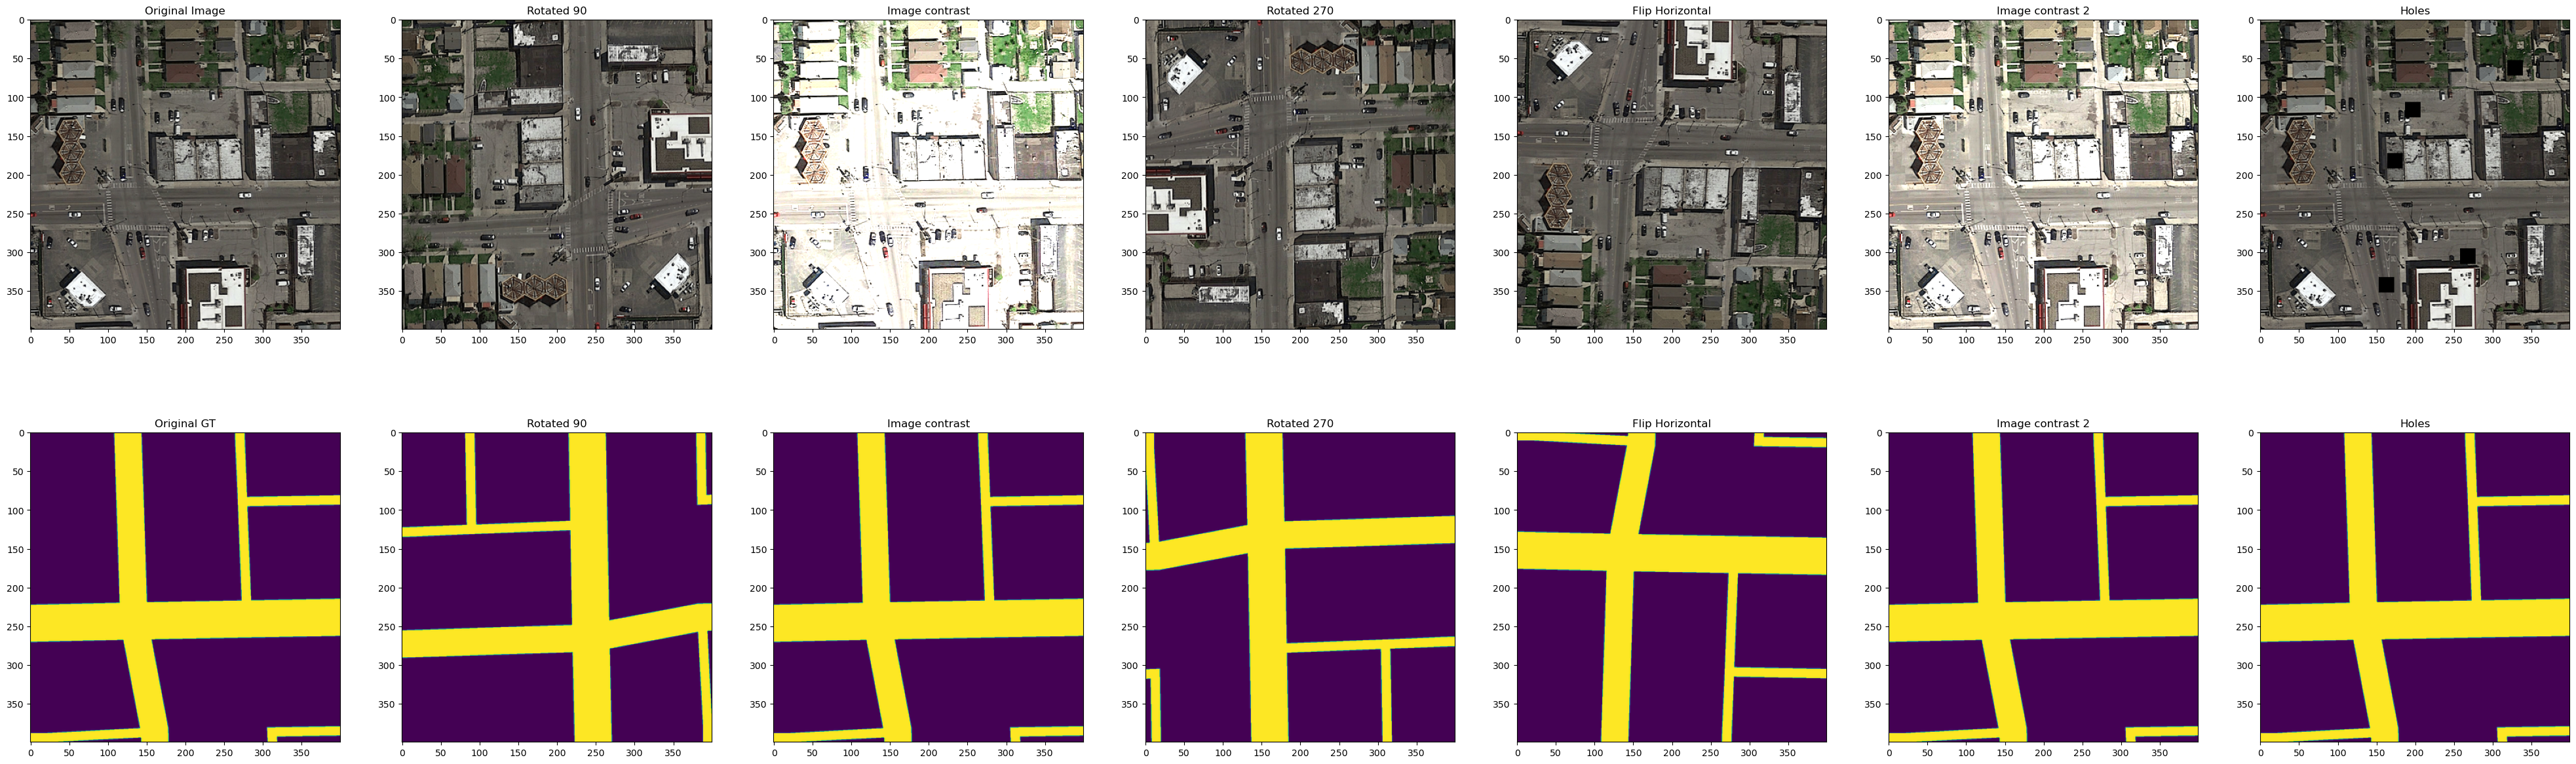

In [6]:
visualize_augmented_data(IMAGES_SRC, IMAGES_GT)

In [7]:
# split data into train and validation sets
src_train, src_val, gt_train, gt_val = train_test_split(IMAGES_SRC, IMAGES_GT, test_size=0.2, random_state=42)

In [8]:
augmented_src, augmented_gt = huge_augment_data(src_train, gt_train) if USE_HUGE_DATA_AUGMENTATION else augment_data(src_train, gt_train)

## crop

In [9]:
def flatten(arr):
  # without numpy
  return [item for sublist in arr for item in sublist]

cropped_src, cropped_gt = [img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src], [img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]
cropped_src, cropped_gt = flatten(cropped_src), flatten(cropped_gt)
# remove patches of incorrect size with zip
cropped_src, cropped_gt = zip(*[(img, gt) for img, gt in zip(cropped_src, cropped_gt) if img.shape == (PATCH_SIZE, PATCH_SIZE, 3)])
cropped_src, cropped_gt = np.asarray(cropped_src), np.asarray(cropped_gt)

# Add extra dataset (if enabled)

In [10]:
if USE_EXTRA_DATASET:
    extra_cropped_src, extra_cropped_gt = [img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in EXTRA_SRC], [img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in EXTRA_GT]
    extra_cropped_src, extra_cropped_gt = flatten(extra_cropped_src), flatten(extra_cropped_gt)
    extra_cropped_src, extra_cropped_gt = zip(*[(img, gt) for img, gt in zip(extra_cropped_src, extra_cropped_gt) if img.shape == (PATCH_SIZE, PATCH_SIZE, 3)])
    extra_cropped_src, extra_cropped_gt = np.asarray(extra_cropped_src), np.asarray(extra_cropped_gt)
    cropped_src = np.concatenate((cropped_src, extra_cropped_src))
    cropped_gt = np.concatenate((cropped_gt, extra_cropped_gt))

# Normalization

In [11]:
def get_mean_std(imgs):
  """
  Normalizes images with mean and standard deviation, by channel
  """
  mean = imgs.mean(axis=(0, 1, 2))
  std = imgs.std(axis=(0, 1, 2))

  return mean, std

means, stds = get_mean_std(cropped_src)

# Dataset loading

In [12]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

ds_src, ds_gt = torch.stack([img_transform(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([35049, 3, 96, 96])
torch.Size([35049, 96, 96])


In [13]:
dataset = TensorDataset(ds_src, ds_gt)

# Test dataset

In [14]:
def generate_test_ds():
  src, gt = [img_crop(img, TEST_PATCH_SIZE, TEST_PATCH_SIZE) for img in src_val], [img_crop(img, TEST_PATCH_SIZE, TEST_PATCH_SIZE) for img in gt_val]
  src, gt = flatten(src), flatten(gt)
  # remove patches of incorrect size with zip
  src, gt = zip(*[(img, gt) for img, gt in zip(src, gt) if img.shape == (TEST_PATCH_SIZE, TEST_PATCH_SIZE, 3)])
  src, gt = np.asarray(src), np.asarray(gt)

  return TensorDataset(torch.stack([img_transform(i) for i in src]), torch.stack([transforms.ToTensor()(i) for i in gt]).squeeze())


test_ds = generate_test_ds()

# Model definition

In [65]:
from road_segmentation.models import UNet, DinkNet34

model=UNet(n_channels=3, n_classes=1) # DinkNet34() for DinkNet
summary(model, input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [6, 96, 96]               --
├─DoubleConv: 1-1                             [6, 64, 96, 96]           --
│    └─Sequential: 2-1                        [6, 64, 96, 96]           --
│    │    └─Conv2d: 3-1                       [6, 64, 96, 96]           1,728
│    │    └─BatchNorm2d: 3-2                  [6, 64, 96, 96]           128
│    │    └─ReLU: 3-3                         [6, 64, 96, 96]           --
│    │    └─Conv2d: 3-4                       [6, 64, 96, 96]           36,864
│    │    └─BatchNorm2d: 3-5                  [6, 64, 96, 96]           128
│    │    └─ReLU: 3-6                         [6, 64, 96, 96]           --
├─Down: 1-2                                   [6, 128, 48, 48]          --
│    └─Sequential: 2-2                        [6, 128, 48, 48]          --
│    │    └─MaxPool2d: 3-7                    [6, 64, 48, 48]           --
│    │    └

# Training!

In [16]:
from tqdm.notebook import tqdm
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    t = tqdm(train_loader, total=len(train_loader))
    for data, target in t:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)#[None, ...]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        t.set_postfix({"loss": loss.item()})
        acc_history.append(((output > 0).eq(target > 0).sum() / target.numel()).item())

    return acc_history, loss_history

In [17]:
def train(device, batch_size=32, epochs=60, start_epoch=0):
    pytorchDl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.BCEWithLogitsLoss()

    for i in tqdm(range(start_epoch, epochs)):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

        print("saving…")
        torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))

        for threshold in [0.10, 0.18, 0.25, 0.5, 0.75]:
          f1 = compute_f1(test_ds, model, device, threshold=threshold)
          print(f"F1 (threshold={threshold}): ", f1)

    return

In [ ]:
train(device, 64, 250, 0)

# F1 with different parameters

In [ ]:
for threshold in np.linspace(0.1, 1, 50):
  f1 = compute_f1(test_ds, model, device, threshold=threshold)
  print("Threshold: ", threshold, " F1: ", compute_f1(test_ds, model, device, threshold=threshold))

# Visualize results?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


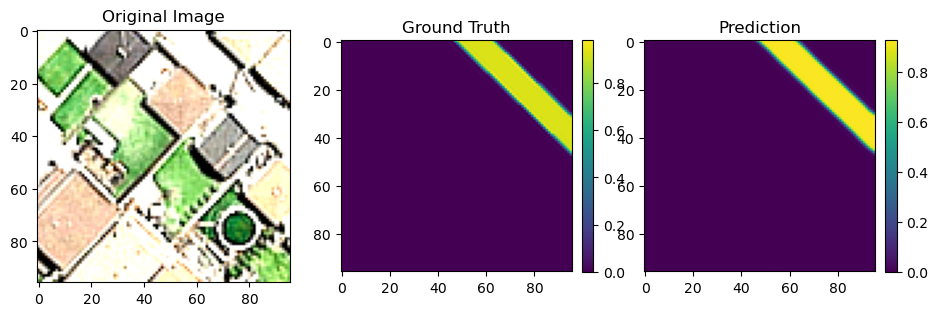

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 384, 384])


In [57]:
visualize_result(device, model, dataset)
visualize_result(device, model, test_ds)

# Making a submission

In [ ]:
import time

TEST_SET_FOLDER = os.path.abspath("data/test_set_images")
SUBMISSION_NAME = f"submission_{time.time()}.csv"

SUBMISSION_PATH = os.path.abspath("submissions/" + SUBMISSION_NAME)

make_submission(model, device, img_transform, SUBMISSION_PATH, TEST_SET_FOLDER, constrast=1, threshold=0.1367)